# Domain Conservation Analysis

<img src="../figures/domain_conservation.svg" alt="Domain Conservation Analysis" width="300px">

Protein domains are like building blocks in proteins—they keep their shape and function even when their sequences change over time. We wanted to see how different tokenization methods handle these changes, so we ran an experiment. The goal was to check the consistency of tokenization patterns across domain variants—instances of the same domain appearing in different proteins. Our hypothesis was that evoBPE, which is designed to be aware of evolutionary relationships, would break down protein sequences in a more consistent way than standard BPE.

In [ ]:
import sqlite3
import pandas as pd
from tqdm import tqdm
import numpy as np
from tokenizers import Tokenizer
import json
import random
from collections import Counter
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices
from vocabulary_functions import get_mutated, get_parents, set_difference, set_intersection, load_tokenizers, calc_agreement, calc_dice_idx_only

In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=20)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load Tokenizers

In [ ]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
vocab_sizes = [800, 1600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

In [5]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items()]))

In [6]:
methods = [method_name[:-len(str(vocab_sizes[0]))-1] for method_name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn:mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}
methods2names

{'stdBPE': 'BPE'}

## Read Datasets

In [ ]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)

df_interpro_domain = pd.read_sql(f"SELECT uniprot_id, interpro_id as source, start_index, end_index FROM interpro_entries_v2 WHERE type='domain'", conn)
df_ted = pd.read_sql(f"SELECT uniprot_id, ted_id as source, start_index, end_index FROM ted_entries_summary WHERE plddt >= 70", conn)

conn.close()

In [8]:
df_domains = pd.concat([df_interpro_domain, df_ted])
# Find uniprot_ids that have "interpro" as a source
interpro_ids = df_domains.loc[df_domains["source"].str.startswith("IPR"), "uniprot_id"].unique()
# Filter the DataFrame to exclude rows with source "ted" for those uniprot_ids
df_domains = df_domains[~((df_domains["uniprot_id"].isin(interpro_ids)) & (df_domains["source"].str.startswith("AF")))]
df_domains = df_protein.set_index('uniprot_id').join(df_domains.set_index('uniprot_id'), how='inner').reset_index()
df_domains['domain_sequence'] = df_domains.apply(lambda row: row['sequence'][row['start_index']-1: row['end_index']], axis=1)
df_domains = df_domains[df_domains['domain_sequence'].str.len()>0]

df_domains = df_domains[df_domains['source'].str.startswith('IPR')] # just keep interpro entries

df_domains = df_domains[['uniprot_id', 'source', 'domain_sequence']].reset_index(drop=True)
df_domains

,uniprot_id,source,domain_sequence
0,A0A087X296,IPR000742,PVNPCCYYPCQHQGICVRFGLDRYQCDCTRTGYSGPNCT
1,A0A0K2S4Q6,IPR003599,PSTVMGAVGESLSVQCRYEEKYKTFNKYWCRQPCLPIWHEMVETGG...
2,A0A0K2S4Q6,IPR007110,PGCLTVSGPSTVMGAVGESLSVQCRYEEKYKTFNKYWCRQPCLPIW...
3,A0A0K2S4Q6,IPR013106,GPSTVMGAVGESLSVQCRYEEKYKTFNKYWCRQPCLPIWHEMVETG...
4,A0A3B3ISZ0,IPR001206,AQVKKATVFLNPAACKGKARTLFEKNAAPILHLSGMDVTIVKTDYE...
...,...,...,...
99798,X6RHN7,IPR028889,KGLSNEPGQNSCFLNSALQVLWHLDIFRRSFRQLTTHKCMGDSCIF...
99799,X6RIL1,IPR005302,RPRRPHQIADLFRPKDQIAYSDTSPFLILSEASLADLNSRLEKKVK...
99800,X6RK39,IPR025946,LPRVLRVCSGVYFEGSIYEISGNECCLSTGDLIKVTQVRLQKVVCE...
99801,X6RK39,IPR025946,ILEVPEGRPIFLSPWVGSLQKGQRLCVYGLASPPWRVLASSKGRKV...


In [8]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    df_domains[name] = [enc.tokens for enc in tokenizer.encode_batch(df_domains['domain_sequence'])]

100%|██████████| 30/30 [00:43<00:00,  1.45s/it]


In [9]:
df_domains.head()

,uniprot_id,source,domain_sequence,stdBPE 800,stdBPE 1600,stdBPE 3200,stdBPE 6400,stdBPE 12800,stdBPE 25600,mutBPE blosum62 0.7 0.05 800,...,mutBPE pre blosum62 0.7 0.05 3200,mutBPE pre blosum62 0.7 0.05 6400,mutBPE pre blosum62 0.7 0.05 12800,mutBPE pre blosum62 0.7 0.05 25600,mutBPE pre pam70 0.7 0.05 800,mutBPE pre pam70 0.7 0.05 1600,mutBPE pre pam70 0.7 0.05 3200,mutBPE pre pam70 0.7 0.05 6400,mutBPE pre pam70 0.7 0.05 12800,mutBPE pre pam70 0.7 0.05 25600
0,A0A087X296,IPR000742,PVNPCCYYPCQHQGICVRFGLDRYQCDCTRTGYSGPNCT,"[PV, N, PC, C, YY, PC, QH, QG, I, CV, RF, GLD,...","[PV, N, PC, C, YY, PC, QH, QGI, CV, RF, GLD, R...","[PVN, PCC, YY, PC, QH, QGI, CV, RF, GLD, RYQ, ...","[PVN, PCC, YY, PC, QH, QGI, CV, RF, GLD, RYQ, ...","[PVN, PCC, YY, PC, QH, QGI, CV, RF, GLD, RYQ, ...","[PVN, PCC, YY, PC, QH, QGI, CV, RF, GLD, RYQ, ...","[PV, N, PC, C, YY, PC, QH, QG, I, CV, RF, GL, ...",...,"[PV, N, PC, C, YY, PC, QH, QGI, CV, RF, GLD, R...","[PV, NPC, C, YY, PC, QH, QGI, CV, RF, GLD, RY,...","[PV, NPC, C, YY, PC, QH, QGI, CV, RF, GLD, RY,...","[PV, NPC, C, YY, PC, QH, QGI, CV, RF, GLD, RY,...","[PV, N, PC, C, YY, PC, QH, QG, I, CV, RF, GL, ...","[PV, N, PC, C, YY, PC, QH, QG, I, CV, RF, GLD,...","[PV, N, PC, C, YY, PC, QH, QGI, CV, RF, GLD, R...","[PV, N, PCC, YY, PC, QH, QGI, CV, RF, GLD, RY,...","[PV, N, PCC, YY, PC, QH, QGI, CV, RF, GLD, RY,...","[PV, N, PCC, YY, PC, QH, QGI, CV, RF, GLD, RY,..."
1,A0A0K2S4Q6,IPR003599,PSTVMGAVGESLSVQCRYEEKYKTFNKYWCRQPCLPIWHEMVETGG...,"[PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, KT,...","[PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, KT,...","[PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, KT,...","[PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, KT,...","[PSTV, MG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PSTV, MG, AVG, ESL, SV, QC, RYEE, KY, KT, FN,...","[PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, KT,...",...,"[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KTFN,...","[PST, V, MG, AV, G, ESL, SV, QC, RY, EE, KY, K...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F...","[PST, VMG, AVG, ESL, SV, QC, RY, EE, KY, KT, F..."
2,A0A0K2S4Q6,IPR007110,PGCLTVSGPSTVMGAVGESLSVQCRYEEKYKTFNKYWCRQPCLPIW...,"[PG, CL, TV, SG, PST, V, MG, AVG, ESL, SV, QC,...","[PG, CL, TV, SG, PST, V, MG, AVG, ESL, SV, QC,...","[PG, CL, TV, SG, PST, V, MG, AVG, ESL, SV, QC,...","[PG, CL, TV, SG, PST, V, MG, AVG, ESL, SV, QC,...","[PG, CL, TVSG, PSTV, MG, AVG, ESL, SV, QC, RY,...","[PGCL, TVSG, PSTV, MG, AVG, ESL, SV, QC, RYEE,...","[PG, CL, TV, SG, PST, V, MG, AVG, ESL, SV, QC,...",...,"[PG, CL, TV, SG, PST, VMG, AVG, ESL, SV, QC, R...","[PG, CL, TV, SG, PST, VMG, AVG, ESL, SV, QC, R...","[PG, CL, TVSG, PST, VMG, AVG, ESL, SV, QC, RY,...","[PGCL, TVSG, PST, VMG, AVG, ESL, SV, QC, RY, E...","[PG, CL, TV, SG, PST, V, MG, AV, G, ESL, SV, Q...","[PG, CL, TV, SG, PST, VMG, AVG, ESL, SV, QC, R...","[PG, CL, TV, SG, PST, VMG, AVG, ESL, SV, QC, R...","[PG, CL, TV, SG, PST, VMG, AVG, ESL, SV, QC, R...","[PG, CL, TVSG, PST, VMG, AVG, ESL, SV, QC, RY,...","[PG, CL, TVSG, PST, VMG, AVG, ESL, SV, QC, RY,..."
3,A0A0K2S4Q6,IPR013106,GPSTVMGAVGESLSVQCRYEEKYKTFNKYWCRQPCLPIWHEMVETG...,"[G, PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, ...","[G, PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, ...","[G, PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, ...","[G, PST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, ...","[G, PSTV, MG, AVG, ESL, SV, QC, RY, EE, KY, KT...","[G, PSTV, MG, AVG, ESL, SV, QC, RYEE, KY, KT, ...","[GP, ST, V, MG, AVG, ESL, SV, QC, RY, EE, KY, ...",...,"[GP, STV, MG, AVG, ESL, SV, QC, RY, EE, KY, KT...","[GP, STV, MG, AVG, ESL, SV, QC, RY, EE, KY, KT...","[GP, STV, MG, AVG, ESL, SV, QC, RY, EE, KY, KT...","[GP, STV, MG, AVG, ESL, SV, QC, RY, EE, KY, KT...","[G, PST, V,

### Helper Functions

In [ ]:
def group_similar_length_lists(lst, threshold):
    """
    Example usage
    list_of_lists = [
        ["apple", "banana"],
        ["pear", "peach", "grape"],
        ["kiwi", "mango"],
        ["strawberry"],
        ["blueberry", "blackberry", "raspberry"],
        ["cherry", "plum"]
    ]
    threshold = 5

    groups, ungrouped = group_similar_length_lists(list_of_lists.copy(), threshold)

    Groups:
    (['kiwi', 'mango'], ['cherry', 'plum'])
    (['apple', 'banana'], ['pear', 'peach', 'grape'])

    Ungrouped:
    ['strawberry']
    ['blueberry', 'blackberry', 'raspberry']
    """
    
    find_length = lambda x: len(x) if type(x) is not list else sum(len(s) for s in x)

    lst_cpy = lst.copy()
    # Shuffle the lists randomly
    random.shuffle(lst_cpy)

    groups = []  # To store the resulting groups
    ungrouped = []  # To store lists that cannot be grouped

    while lst_cpy:
        # Pop the first list
        lst1 = lst_cpy.pop()
        len1 = find_length(lst1)

        # Find a list to pair with it
        paired = False
        for i, lst2 in enumerate(lst_cpy):
            len2 = find_length(lst2)
            if abs(len1 - len2) <= threshold:
                groups.append((lst1, lst2))
                lst_cpy.pop(i)
                paired = True
                break

        if not paired:
            ungrouped.append(lst1)

    return groups, ungrouped

subs_matrix_set = {opt['subs_matrix'].upper() for opt in tokenizer_opts_list if 'subs_matrix' in opt}

def pairwise_sequence_aligment(seq1, seq2, subs_matrix, open_gap_score=-10, extend_gap_score=-1):
    aligner = PairwiseAligner()
    aligner.mode = "global"  # Use "local" for local alignment
    aligner.substitution_matrix = substitution_matrices.load(subs_matrix)
    aligner.open_gap_score = open_gap_score
    aligner.extend_gap_score = extend_gap_score
    alignments = aligner.align(seq1, seq2)

    aligned_seq1, aligned_seq2 = alignments[0].aligned

    aligned_str1 = ""
    aligned_str2 = ""

    last_pos1 = 0
    last_pos2 = 0

    for (start1, end1), (start2, end2) in zip(aligned_seq1, aligned_seq2):
        aligned_str1 += seq1[last_pos1:start1] + "-" * (start2 - last_pos2) + seq1[start1:end1]
        aligned_str2 += seq2[last_pos2:start2] + "-" * (start1 - last_pos1) + seq2[start2:end2]
        last_pos1 = end1
        last_pos2 = end2

    aligned_str1 += seq1[last_pos1:]
    aligned_str2 += seq2[last_pos2:]

    aligned_str1 += "-" * (max(len(aligned_str1), len(aligned_str1)) - len(aligned_str1))
    aligned_str2 += "-" * (max(len(aligned_str1), len(aligned_str1)) - len(aligned_str2))

    return aligned_str1.replace('-', 'Z'), aligned_str2.replace('-', 'Z')

def group_and_allign(lst, threshold):
    def contains_any(target_string):
        return any(char in {'J', 'U', 'O'} for char in target_string)
    
    groups, _ = group_similar_length_lists(lst, threshold)
    new_list = {subs_matrix:[] for subs_matrix in subs_matrix_set}
    for seq1, seq2 in groups:
        if contains_any(seq1) or contains_any(seq2):
            pass
        for subs_matrix in subs_matrix_set:
            try:
                aligned_seq1, aligned_seq2 = pairwise_sequence_aligment(seq1, seq2, subs_matrix)
                new_list[subs_matrix].append((aligned_seq1, aligned_seq2))
            except:
                pass

    return new_list

def calc_agreement_groups(groups):
    dice_coef_list = [calc_agreement(l1, l2) for l1, l2 in groups]
    return np.round(np.mean(dice_coef_list),2)

## Group, Align and Calculate Dice Coefficient

First, we took protein domain sequences from our dataset and grouped them based on their InterPro annotations. Since protein sequences come in different lengths, we paired up domains within each group, making sure that the sequences in each pair weren’t more than five amino acids apart in length. If a domain didn’t have a close enough match, we left it out.

To make the comparison fair, we aligned the sequences in each pair first. Then, we tokenized them and checked how similar their tokenization patterns were by calculating the Dice coefficient—a measure of how much overlap there is between the tokens. To get a big-picture view, we averaged these scores across all the pairs. The higher the Dice score, the better the tokenizer was at keeping the patterns consistent across different versions of the same domain, meaning it did a better job of capturing the biological connections.

In [ ]:
agg_dict = {'uniprot_id': len, 'domain_sequence': list}

df_domains_sequence_agg = df_domains.drop_duplicates(['uniprot_id', 'source']).groupby('source').agg(agg_dict).reset_index()
df_domains_sequence_agg[df_domains_sequence_agg['uniprot_id'] > 1].reset_index()
df_domains_sequence_agg.head()

,source,uniprot_id,domain_sequence
0,IPR000001,45,[EGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPG...
1,IPR000007,11,[LRPAPQGRTVRCRLTRDKKGMDRGMYPSYFLHLDTEKKVFLLAGR...
2,IPR000008,333,[LVSEVQIAQLRFPVPKGVLRIHFIEAQDLQGKDTYLKGLVKGKSD...
3,IPR000010,21,[VKPGFPKTIKTNDPGVLQAARYSVEKFNNCTNDMFLFKESRITRA...
4,IPR000014,77,[LEGRLLLESLNGFALVVSAEGTIFYASATIVDYLGFHQTDVMHQN...


In [13]:
df_domains_sequence_aligned_agg = pd.DataFrame.from_dict(list(df_domains_sequence_agg['domain_sequence'].parallel_apply(group_and_allign, args=(10,))))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [14]:
df_domains_sequence_aligned_agg = pd.concat([df_domains_sequence_agg[['source', 'domain_sequence']], df_domains_sequence_aligned_agg], axis=1)
df_domains_sequence_aligned_agg = df_domains_sequence_aligned_agg.drop(df_domains_sequence_aligned_agg[df_domains_sequence_aligned_agg['BLOSUM62'].apply(lambda x: x == [])].index).reset_index(drop=True)

In [15]:
df_domains_sequence_aligned_tokenizer_agg = df_domains_sequence_aligned_agg[list(subs_matrix_set)].map(lambda lst: np.array(lst).flatten().tolist())
df_domains_sequence_aligned_tokenizer_agg['sequence_count'] = df_domains_sequence_aligned_tokenizer_agg['PAM70'].str.len()

In [16]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    chosen_matrix = ''
    for subs_matrix in subs_matrix_set:
        if subs_matrix.lower() in name:
            chosen_matrix = subs_matrix
    if chosen_matrix != '':
        temp_series = df_domains_sequence_aligned_tokenizer_agg[chosen_matrix].apply(lambda lst: [enc.tokens for enc in tokenizer.encode_batch(lst)])
        df_domains_sequence_aligned_tokenizer_agg[name] = temp_series.apply(lambda x: [(x[i], x[i+1]) for i in range(0,len(x),2)])
    else:
        temp_series = df_domains_sequence_aligned_tokenizer_agg['BLOSUM62'].apply(lambda lst: [enc.tokens for enc in tokenizer.encode_batch(lst)])
        df_domains_sequence_aligned_tokenizer_agg[name] = temp_series.apply(lambda x: [(x[i], x[i+1]) for i in range(0,len(x),2)])

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


In [17]:
df_domains_sequence_aligned_tokenizer_agg = pd.concat([df_domains_sequence_aligned_agg[['source']], df_domains_sequence_aligned_tokenizer_agg], axis=1)
df_domains_sequence_aligned_tokenizer_agg.head()

,source,BLOSUM62,PAM70,sequence_count,stdBPE 800,stdBPE 1600,stdBPE 3200,stdBPE 6400,stdBPE 12800,stdBPE 25600,...,mutBPE pre blosum62 0.7 0.05 3200,mutBPE pre blosum62 0.7 0.05 6400,mutBPE pre blosum62 0.7 0.05 12800,mutBPE pre blosum62 0.7 0.05 25600,mutBPE pre pam70 0.7 0.05 800,mutBPE pre pam70 0.7 0.05 1600,mutBPE pre pam70 0.7 0.05 3200,mutBPE pre pam70 0.7 0.05 6400,mutBPE pre pam70 0.7 0.05 12800,mutBPE pre pam70 0.7 0.05 25600
0,IPR000001,[NSDCYFGNGSAYRGTHSLTESGASCLPWNSMILIGKVYTZAQNPS...,[NSDCYFGNGSAYRGTHSLTESGASCLPWNSMILIGKVYTZZZZZZ...,42,"[([N, SD, CY, FG, NG, SA, Y, RG, TH, SL, TE, S...","[([N, SD, CY, FG, NG, SAY, RG, TH, SL, TE, SGA...","[([N, SD, CY, FG, NG, SAY, RG, TH, SL, TE, SGA...","[([N, SD, CY, FG, NG, SAY, RG, TH, SL, TE, SGA...","[([NSD, CY, FG, NG, SAY, RG, TH, SL, TE, SGA, ...","[([NSD, CY, FGNG, SAY, RG, THSL, TE, SGA, SCL,...",...,"[([NSD, CY, FG, NG, SA, YRG, TH, SL, TE, SGA, ...","[([NSD, CY, FG, NG, SA, YRG, TH, SL, TE, SGA, ...","[([NSD, CY, FG, NG, SA, YRG, TH, SL, TE, SGA, ...","[([NSD, CY, FGNG, SA, YRG, THSL, TE, SGA, SCL,...","[([NSD, CY, FG, NG, SA, Y, RG, TH, SL, TE, SG,...","[([NSD, CY, FG, NG, SA, Y, RG, TH, SL, TE, SG,...","[([NSD, CY, FG, NG, SA, YRG, TH, SL, TE, SG, A...","[([NSD, CY, FG, NG, SA, YRG, TH, SL, TE, SGA, ...","[([NSD, CY, FG, NG, SA, YRG, TH, SL, TE, SGA, ...","[([NSD, CY, FGNG, SA, YRG, THSL, TE, SGA, SCL,..."
1,IPR000007,[ZRPAPQGITIKCRITRDKKGMDRGMYPTYFLHLDREDGKKVFLLA...,[ZRPAPQGITIKCRITRDKKGMDRGMYPTYFLHLDREDGKKVFLLA...,6,"[([Z, R, PA, PQ, GI, TI, KC, RI, T, RD, KKG, M...","[([Z, RPA, PQ, GI, TI, KC, RIT, RD, KKG, MD, R...","[([Z, RPA, PQ, GI, TI, KC, RIT, RD, KKG, MD, R...","[([Z, RPA, PQ, GI, TI, KC, RIT, RD, KKG, MD, R...","[([Z, RPA, PQGI, TI, KC, RIT, RD, KKG, MD, RG,...","[([Z, RPA, PQGI, TI, KC, RIT, RD, KKG, MDRG, M...",...,"[([Z, RPA, PQ, GI, TI, KC, RI, T, RD, KKG, MD,...","[([Z, RPA, PQGI, TI, KC, RI, TRD, KKG, MD, RG,...","[([Z, RPA, PQGI, TI, KC, RI, TRD, KKG, MD, RG,...","[([Z, RPA, PQGI, TIKC, RI, TRD, KKG, MD, RG, M...","[([Z, R, PA, PQ, GI, TI, KC, RI, T, RD, KK, G,...","[([Z, RPA, PQ, GI, TI, KC, RI, T, RD, KK, G, M...","[([Z, RPA, PQ, GI, TI, KC, RI, TRD, KKG, MD, R...","[([Z, RPA, PQ, GI, TI, KC, RI, TRD, KKG, MD, R...","[([Z, RPA, PQ, GI, TI, KC, RI, TRD, KKG, MD, R...","[([Z, RPA, PQGI, TI, KC, RI, TRD, KKG, MD, RG,..."
2,IPR000008,[QTQSLRLSDLHRKSHLWRGIVSZZZZITLIEGRDLKAMDSNGLSD...,[QTQSLRLSZDLHRKSHLWRGIVSZZZZITLIEGRDLKAMDSNGLS...,328,"[([Q, TQ, SL, RL, SDL, H, RK, SHL, W, RG, IV, ...","[([Q, TQ, SL, RL, SDL, H, RK, SHL, W, RG, IV, ...","[([Q, TQ, SLRL, SDL, H, RK, SHL, W, RG, IV, S,...","[([Q, TQ, SLRL, SDL, H, RK, SHL, WRG, IV, S, Z...","[([Q, TQ, SLRL, SDL, HRK, SHL, WRG, IV, S, Z, ...","[([Q, TQ, SLRL, SDL, HRK, SHL, WRG, IV, S, Z, ...",...,"[([QTQ, SL, RL, SDL, HRK, SHL, WRG, IV, S, Z, ...","[([QTQ, SLRL, SDL, HRK, SHL, WRG, IV, S, Z, Z,...","[([QTQ, SLRL, SDL, HRK, SHL, WRG, IV, S, Z, Z,...","[([QTQ, SLRL, SDL, HRK, SHL, WRG, IV, S, Z, Z,...","[([Q, TQ, SL, RL, S, Z, DL, H, RK, SHL, W, RG,...","[([Q, TQ, SL, RLS, Z, DL, H, RK, SHL, W, RG, I...","[([QTQ, SL, RLS, Z, DL, HRK, SHL, W, RG, IV, S...","[([QTQ, SL, RLS, Z, DL, HRK, SHL, WRG, IV, S, ...","[([QTQ, SL, RLS, Z, DL, HRK, SHL, WRG, IV, S, ...","[([QTQ, SL, RLS, Z, DL, HRK, SHL, WRG, IV, S, ..."
3,IPR000010,[VKPGFPKTIKTNDPGVLQAARYSVEKFNNCTNZDMFLFKESRITR...,[VKPGFPKTIKTNDPGVLQAARYSVEKFNNCTNDMFLFKESRITRA...,18,"[([VK, PG, F, PK, TI, KT, ND, PG, VLQ, AA, RY,...","[([VK, PG, F, PK, TI, KT, ND, PG, VLQ, AA, RY,...","[([VK, PG, FPK, TI, KT, ND, PG, VLQ, AA, RY, S...","[([VK, PG, FPK, TI, KT, ND, PG, VLQ, AA, RY, S...","[([VK, PG, FPK, TI, KT, ND, PG, VLQ, AA, RY, S...","[([VK, PG, FPK, TI, KT, ND, PG, VLQ, AA, RY, S...",...,"[([V, KPG, F, PK, TI, KT, ND, PG, VL, QAA, RY,...","[([V, KPG, FPK, TI, KT, ND, PG, VL, QAA, RY, S...","[([V, KPG, FPK, TI, KT, ND, PGVL, QAA, RY, SV,...","[([V, KPG, FPK, TI, KT, ND, PGVL, QAA, RY, SV,...","[([VK, PG, F, PK, TI, KT, ND, PG, VL, QAA, RY,...","[([VK, PGF, PK,

In [ ]:
df_domains_pairwise_aligned_dice = df_domains_sequence_aligned_tokenizer_agg.iloc[:, 4:].map(calc_agreement_groups)
df_domains_pairwise_aligned_dice = pd.concat([df_domains_sequence_aligned_tokenizer_agg[['sequence_count']], df_domains_pairwise_aligned_dice], axis=1)
df_domains_pairwise_aligned_dice.head()

,sequence_count,stdBPE 800,stdBPE 1600,stdBPE 3200,stdBPE 6400,stdBPE 12800,stdBPE 25600,mutBPE blosum62 0.7 0.05 800,mutBPE blosum62 0.7 0.05 1600,mutBPE blosum62 0.7 0.05 3200,...,mutBPE pre blosum62 0.7 0.05 3200,mutBPE pre blosum62 0.7 0.05 6400,mutBPE pre blosum62 0.7 0.05 12800,mutBPE pre blosum62 0.7 0.05 25600,mutBPE pre pam70 0.7 0.05 800,mutBPE pre pam70 0.7 0.05 1600,mutBPE pre pam70 0.7 0.05 3200,mutBPE pre pam70 0.7 0.05 6400,mutBPE pre pam70 0.7 0.05 12800,mutBPE pre pam70 0.7 0.05 25600
0,42,0.64,0.63,0.60,0.59,0.56,0.53,0.66,0.64,0.61,...,0.60,0.58,0.56,0.54,0.66,0.64,0.61,0.59,0.55,0.54
1,6,0.78,0.74,0.72,0.71,0.67,0.66,0.78,0.76,0.70,...,0.71,0.68,0.65,0.60,0.79,0.77,0.74,0.72,0.72,0.69
2,328,0.66,0.62,0.59,0.57,0.54,0.51,0.67,0.64,0.61,...,0.61,0.59,0.56,0.53,0.69,0.65,0.62,0.60,0.58,0.55
3,18,0.64,0.60,0.57,0.55,0.53,0.50,0.65,0.63,0.60,...,0.60,0.58,0.56,0.54,0.69,0.65,0.61,0.60,0.57,0.54
4,72,0.70,0.66,0.65,0.62,0.60,0.58,0.72,0.69,0.67,...,0.67,0.65,0.63,0.61,0.73,0.70,0.68,0.66,0.64,0.62


## Results

In [20]:
np.mean(df_domains_pairwise_aligned_dice.iloc[:,1:], axis=0).sort_values(ascending=False)

mutBPE pre pam70 0.7 0.05 800         0.867500
mutBPE pam70 0.7 0.05 800             0.866781
mutBPE pre blosum62 0.7 0.05 800      0.862781
mutBPE blosum62 0.7 0.05 800          0.862271
stdBPE 800                            0.855228
mutBPE pre pam70 0.7 0.05 1600        0.854096
mutBPE pam70 0.7 0.05 1600            0.852990
mutBPE pre blosum62 0.7 0.05 1600     0.850662
mutBPE blosum62 0.7 0.05 1600         0.849855
mutBPE pre pam70 0.7 0.05 3200        0.840705
stdBPE 1600                           0.839918
mutBPE pam70 0.7 0.05 3200            0.838685
mutBPE pre blosum62 0.7 0.05 3200     0.837469
mutBPE blosum62 0.7 0.05 3200         0.836930
mutBPE pre pam70 0.7 0.05 6400        0.829789
mutBPE pam70 0.7 0.05 6400            0.827348
mutBPE pre blosum62 0.7 0.05 6400     0.826863
mutBPE blosum62 0.7 0.05 6400         0.826596
stdBPE 3200                           0.826160
mutBPE pre pam70 0.7 0.05 12800       0.818669
mutBPE pre blosum62 0.7 0.05 12800    0.816418
mutBPE pam70 

In [21]:
pd.Series(dict(zip(tokenizer_list.keys(), np.average(df_domains_pairwise_aligned_dice.dropna().iloc[:,1:],axis=0,weights=df_domains_pairwise_aligned_dice.dropna()['sequence_count'])))).sort_values(ascending=False)

mutBPE pre pam70 0.7 0.05 800         0.751413
mutBPE pam70 0.7 0.05 800             0.750478
mutBPE blosum62 0.7 0.05 800          0.737693
mutBPE pre blosum62 0.7 0.05 800      0.737655
mutBPE pre pam70 0.7 0.05 1600        0.725971
mutBPE pam70 0.7 0.05 1600            0.724529
stdBPE 800                            0.724012
mutBPE pre blosum62 0.7 0.05 1600     0.714243
mutBPE blosum62 0.7 0.05 1600         0.713663
mutBPE pre pam70 0.7 0.05 3200        0.701051
mutBPE pam70 0.7 0.05 3200            0.698576
stdBPE 1600                           0.695357
mutBPE blosum62 0.7 0.05 3200         0.689777
mutBPE pre blosum62 0.7 0.05 3200     0.689341
mutBPE pre pam70 0.7 0.05 6400        0.680805
mutBPE pam70 0.7 0.05 6400            0.678235
mutBPE blosum62 0.7 0.05 6400         0.671303
stdBPE 3200                           0.670123
mutBPE pre blosum62 0.7 0.05 6400     0.670026
mutBPE pre pam70 0.7 0.05 12800       0.661161
mutBPE pam70 0.7 0.05 12800           0.658776
mutBPE blosum

In [22]:
sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred']
markers = ["o--", "d--", "*--", "X--", "P--", "p--"]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

In [23]:
df = pd.Series(dict(zip(tokenizer_list.keys(), np.average(df_domains_pairwise_aligned_dice.dropna().iloc[:,1:],axis=0,weights=df_domains_pairwise_aligned_dice.dropna()['sequence_count'])))).sort_values(ascending=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


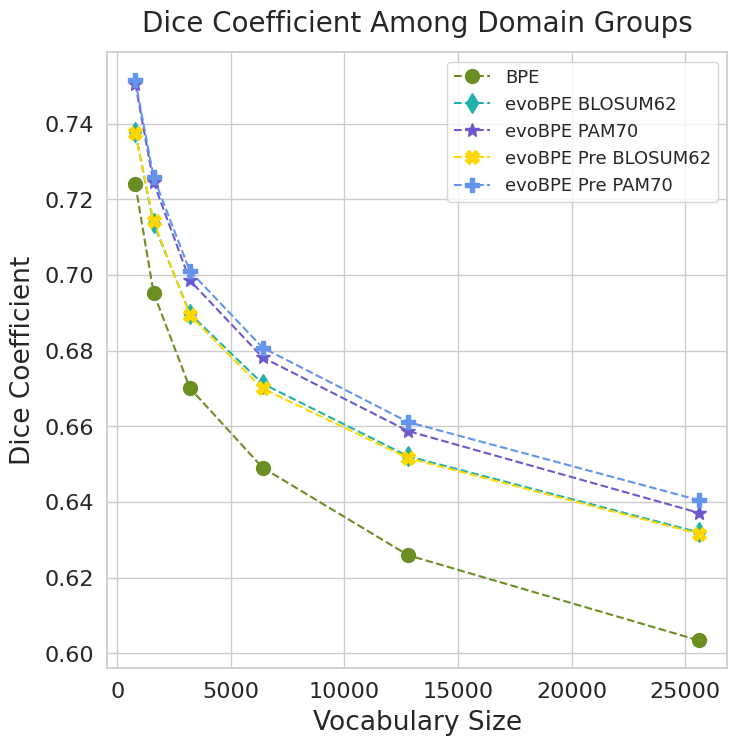

In [26]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [df[f'{method} {vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Dice Coefficient Among Domain Groups", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Dice Coefficient", labelpad=label_pad)
plt.legend()

# plt.xticks(vocab_sizes, rotation=45)
# plt.xlim([0, 2000])
# plt.ylim([2.0, 4])

plt.savefig(f'{figures_folder_name}/dice_domains.eps', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/dice_domains.pdf', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/dice_domains.png', bbox_inches='tight')

plt.show()

### Analysis

Our analysis showed that evoBPE consistently outperformed standard BPE by a large margin, with very little difference between the different evoBPE models. When the vocabulary size was smaller, the scores were higher and more tightly clustered across methods. This makes sense because shorter tokens lead to more similar vocabularies.

But as we increased the vocabulary size, something interesting happened—the gap between evoBPE and standard BPE grew even wider. This tells us that evoBPE was successfully integrating biologically meaningful tokens into its vocabulary, making it much better at capturing important patterns in protein sequences.

Overall, the fact that evoBPE consistently performed better across all vocabulary sizes supports our idea that using evolutionary information—like substitution matrices—helps the tokenizer handle sequence variations in related proteins more effectively.